In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# change your work directory accordingly
%pwd #~/Documents/WQU/assignment_01/

'C:\\Users\\neelkanth mehta\\Documents\\WQU\\machine_learning_for_finance\\assignment_01\\financial-data-structures'

#### Creating time, tick, volume and dollar bars from raw tick data.
<br> The data has been cloned from the provided repo: https://github.com/Jackal08/financial-data-structures.git
* What is referred to as observation in standard machine learning parlance, finance practitioners refer to as 'bars'
* The manner in which bars are organized and stored could broadly be distingueshed into standard and alternate (more advanced) methods.
* Standard approach is to store price dataset per equal time intervals

In [2]:
# Fetching data
tick_ = pd.read_csv('tick_bars.csv').set_index('date')
vol_  = pd.read_csv('volume_bars.csv').set_index('date')
time_ = pd.read_csv('time_bars.csv').set_index('date')
dollar= pd.read_csv('dollar_bars.csv').set_index('date')

In [3]:
# Setting Datatime index
tick_.index  = pd.to_datetime(tick_.index)
vol_.index   = pd.to_datetime(vol_.index)
time_.index  = pd.to_datetime(time_.index)
dollar.index = pd.to_datetime(dollar.index)

          tick      vol     time        $
count  1091.00  1001.00    39.00  1024.00
mean   1677.67  1677.97  1676.31  1678.37
std      25.98    25.88    25.14    25.89
min    1631.25  1631.75  1634.00  1631.50
25%    1654.00  1654.00  1654.12  1654.25
50%    1680.50  1680.50  1680.00  1680.75
75%    1697.12  1697.50  1694.88  1697.75
max    1726.50  1726.25  1721.75  1725.50


(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

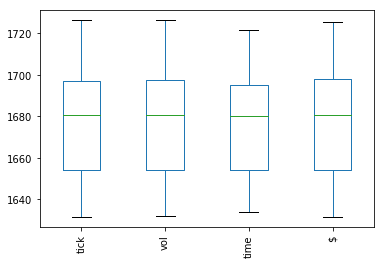

In [25]:
df = pd.concat((tick_['close'], vol_['close'], time_['close'], dollar['close']), axis=1)
df.columns = ['tick', 'vol', 'time', '$']
print(f"{round(df.describe(),2)}")

df.plot.box()
plt.xticks(rotation=90)

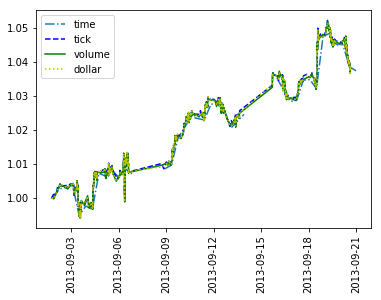

In [4]:
plt.plot(time_['close']/ time_['close'][0], '-.', label='time')
plt.plot(tick_['close']/ tick_['close'][0], 'b--', label='tick')
plt.plot(vol_['close']/ vol_['close'][0], 'g-',label='volume')
plt.plot(dollar['close']/ dollar['close'][0], 'y:',label='dollar')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### What 'bar' type produces the most stable weekly count?
<br> Stable weekly count are referred for least variation in counts over the weeks.

In [5]:
tick_weekly = tick_['close'].resample('W')
vol__weekly =  vol_['close'].resample('W')
time_weekly = time_['close'].resample('W')
dollaweekly =dollar['close'].resample('W')

In [6]:
count_df = pd.concat((tick_weekly.count(), vol__weekly.count(), time_weekly.count(), dollaweekly.count()), axis=1)
count_df.columns = ['tick', 'vol', 'time','dollar']

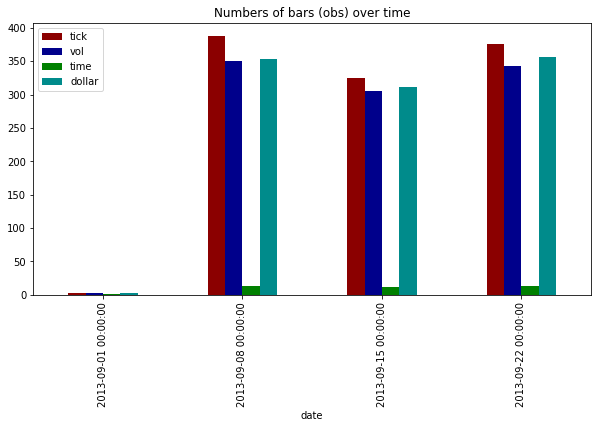

In [7]:
count_df.plot(kind='bar', figsize=[10, 5], color=('darkred', 'darkblue', 'green', 'darkcyan'))
plt.title('Numbers of bars (obs) over time')
plt.show()

#### Checking for thepresence of autocorrelation among the bar types:

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
# plt.acorr(tick_returns, maxlags=10)

In [11]:
time_returns = np.log(time_['close']).diff().dropna()
tick_returns = np.log(tick_['close']).diff().dropna()
vol__returns = np.log(vol_['close']).diff().dropna()
dollarweekly = np.log(dollar['close']).diff().dropna()

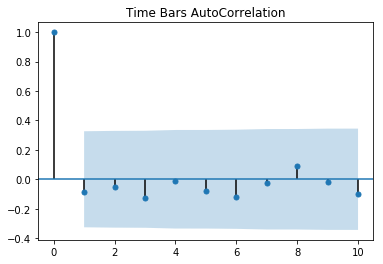

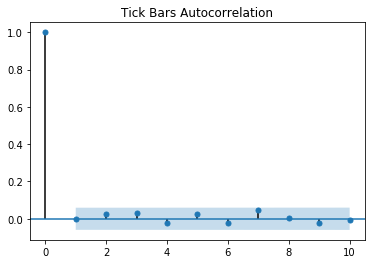

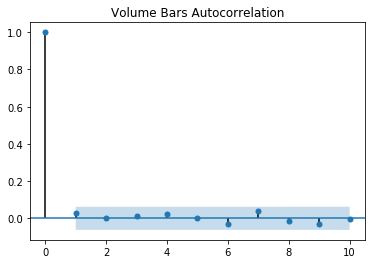

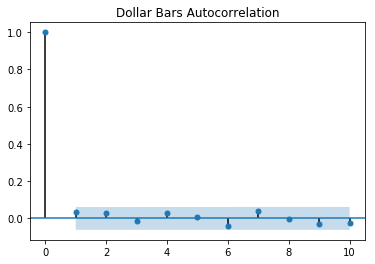

In [16]:
plot_acf(time_returns, lags=10)  # Testing Autocorrelation in time bars
plt.title('Time Bars AutoCorrelation')
plt.show()

plot_acf(tick_returns, lags=10)  # Testing Autocorrelation in tick bars
plt.title('Tick Bars Autocorrelation')
plt.show()

plot_acf(vol__returns, lags=10)  # Testing Autocorrelation in volume bars
plt.title('Volume Bars Autocorrelation')
plt.show()

plot_acf(dollarweekly, lags=10)  # Testing Autocorrelation in dollar bars
plt.title('Dollar Bars Autocorrelation')
plt.show()

#### Test of normality
<br> Most of the statistical mehtods, or machine learning algorithms assume the data is normally and IID...

In [13]:
from scipy.stats import jarque_bera

In [14]:
cols = [tick_returns, vol__returns, time_returns, dollarweekly]
cols_dict = dict(zip(count_df,cols))

In [15]:
for key, value in cols_dict.items():
    print(f"{key} score: {round(jarque_bera(value)[0],3)}; p-val: {round(jarque_bera(value)[1],3)}")

tick score: 4521.614; p-val: 0.0
vol score: 4911.461; p-val: 0.0
time score: 11.518; p-val: 0.003
dollar score: 11916.74; p-val: 0.0
